In [53]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
#choses backend pytorch here if it hasnt already

In [54]:
#reactor constants
L = 1 #m
R_inner = 2.39/1000 #m
R_outer = 3.5/1000 #m

h2Removal = 0 #change to 1 if there is removal of hydrogen

#gas flow constants
T = 622+273 #K
P = 1 #bar or atm

sccm0 = np.array([16.16, 48.48, 0, 0, 10, 5])
mols0 = sccm0/22400 * 60
y0 = mols0/sum(mols0)
print(y0)
Ctot = P/(8.3144598 * 10**-5 * T)

u0 = sum(sccm0) * 273 / T * P / 1 / 60 #cm^3/sec
A = np.pi * ((R_outer*100)**2-(R_inner*100)**2) #cm^2 MIGHT HAVE TO ADJUST THE AREA CALC A BIT
v0 = u0 / A / 100 #m/sec

#rate equation constants
Rgas = 8.314 #J / mol·K
Easmr = 165.740 #kJ/mol
Asmr = 1.68*10**8
Eawgs = 89.23 #kJ/mol
Awgs = 9.90*10**3

Ku = 1

I = 9 #curent in Amps
F = 96485 #faradays constant
Keqsmr = (101325/100000)**2 * np.exp(-26830/T + 30.114)
Keqwgs = np.exp(4400/T - 4.036)

#discritization space
geom = dde.geometry.Interval(0, L)

def odes(x, y):
    Cch4, Ch2o, Cco = y[:, 0:1], y[:, 1:2], y[:, 2:3]
    #JUST ADD TEMP AS A VARIABLE AND YOU ADD THE EQUATION AND CONSTANT IN Y
    
    v = v0*(3*y0[1] - 2*Cch4)/y0[1] # v0*(1+2X)

    rsmr = 2/R_outer*Ku*Asmr*np.exp(-Easmr*1000/Rgas/T)*(1)/Ctot
    rwgs = 2/R_outer*Ku*Asmr*np.exp(-Eawgs*1000/Rgas/T)*(0.5)/Ctot
    rh2r = I/(2*F*L)/Ctot #have not confirmed if this is correct

    #for the jacobian, the i is the component, and then j (ignored here) is the axis (so like are we moving in x-direction or time)
    ch4 = dde.grad.jacobian(y, x, i=0) - (-rsmr)/v
    h2o = dde.grad.jacobian(y, x, i=1) - (-rsmr - rwgs)/v
    co = dde.grad.jacobian(y, x, i=2) - (rsmr - rwgs)/v
    return [ch4, h2o, co]

def bcs(x, on_initial):
    return on_initial and dde.utils.isclose(x[0],0)
    #here t[0] has to be 0 because it is the x-direction axis ("j = 0")

bc_ch4 = dde.DirichletBC(geom, lambda x: 0, bcs, component=0)
bc_h2o = dde.DirichletBC(geom, lambda x: 0, bcs, component=1)
bc_co = dde.DirichletBC(geom, lambda x: 0, bcs, component=2)


[0.20291311 0.60873933 0.         0.         0.12556504 0.06278252]


Compiling model...
'compile' took 0.000937 s



Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [7.77e+02, 1.64e+11, 1.64e+11, 0.00e+00, 0.00e+00, 0.00e+00]    [7.80e+02, 1.65e+11, 1.65e+11, 0.00e+00, 0.00e+00, 0.00e+00]    []  
1000      [5.08e+00, 1.08e+09, 1.08e+09, 8.96e+01, 1.43e-03, 3.67e-01]    [5.08e+00, 1.08e+09, 1.08e+09, 8.96e+01, 1.43e-03, 3.67e-01]    []  
2000      [2.92e+00, 6.22e+08, 6.22e+08, 1.64e+02, 1.21e-05, 2.47e-02]    [2.92e+00, 6.22e+08, 6.22e+08, 1.64e+02, 1.21e-05, 2.47e-02]    []  
3000      [1.98e+00, 4.23e+08, 4.23e+08, 2.46e+02, 3.29e-06, 3.65e-04]    [1.98e+00, 4.23e+08, 4.23e+08, 2.46e+02, 3.29e-06, 3.65e-04]    []  
4000      [1.44e+00, 3.08e+08, 3.08e+08, 3.45e+02, 9.97e-07, 1.67e-05]    [1.44e+00, 3.08e+08, 3.08e+08, 3.45e+02, 9.97e-07, 1.67e-05]    []  
5000      [1.08e+00, 2.31e+08, 2.31e+08, 4.65e+02, 3.35e-07, 3.85e-06]    [1.08e+00, 2.31e+08, 2.31e+08, 4.65e+02, 3

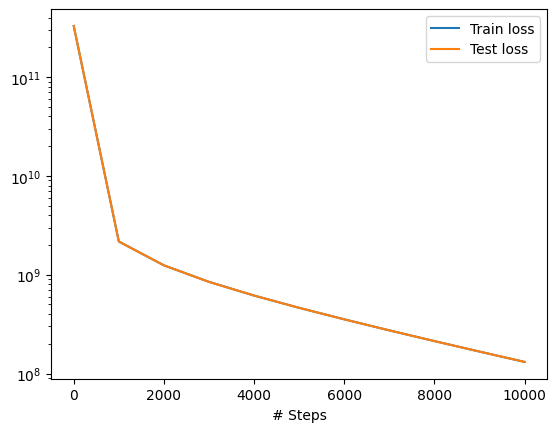

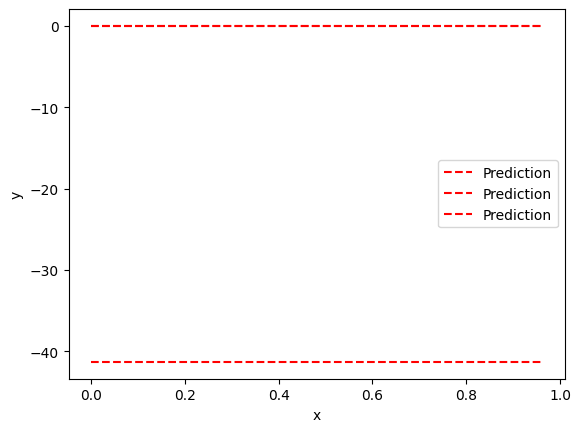

In [55]:
data = dde.data.PDE(geom, 
    odes, 
    [bc_ch4, bc_h2o, bc_co],
    num_domain=150, 
    num_boundary=10, 
    num_test=25)

net = dde.nn.FNN([1] + [20] * 20 + [3], "tanh", "Glorot normal")
model = dde.Model(data, net)
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(iterations=10000)
dde.saveplot(losshistory, train_state, issave=False, isplot=True)